In [274]:
# data processing
import pandas as pd
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# modelling sklearn
from sklearn.metrics import classification_report, auc, confusion_matrix, accuracy_score, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import json

In [275]:
mnist = keras.datasets.mnist
anomalies = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
(anomalous_train_data, anomalous_train_labels), (anomalous_test_data, anomalous_test_labels) = anomalies.load_data()

anomalous_test_data = anomalous_test_data[:100]
anomalous_train_data = anomalous_train_data[:600]
anomalous_test_labels = anomalous_test_labels[:100]
anomalous_train_labels = anomalous_train_labels[:600]

In [276]:
y_test_binary = np.ones(len(y_test))
y_train_binary = np.ones(len(y_train))
anomalous_test_binary = np.zeros(len(anomalous_test_labels))
anomalous_train_binary = np.zeros(len(anomalous_train_labels))

In [277]:
# Create a binary label for normal (1) and anomalies (0)
normal_class = 1
anomaly_class = 0

In [278]:
x_data = np.concatenate((x_train, x_test))
y_labels = np.concatenate((y_test_binary, y_train_binary))
anom_data = np.concatenate((anomalous_train_data, anomalous_test_data))
anom_labels = np.concatenate((anomalous_test_binary, anomalous_train_binary))

data = np.concatenate((x_data, anom_data))
labels = np.concatenate((y_labels, anom_labels))

In [279]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [280]:
# Normalize pixel values to the range [0, 1]
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

train_data = train_data.reshape(-1, 28 * 28)
test_data = test_data.reshape(-1, 28 * 28)

In [281]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

In [282]:
normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anom_train_data = train_data[~train_labels]
anom_test_data = test_data[~test_labels]

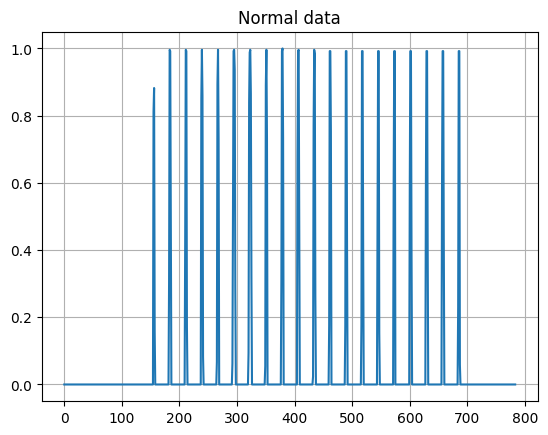

In [283]:
plt.grid()
plt.plot(np.arange(784), normal_train_data[0])
plt.title("Normal data")
plt.show()

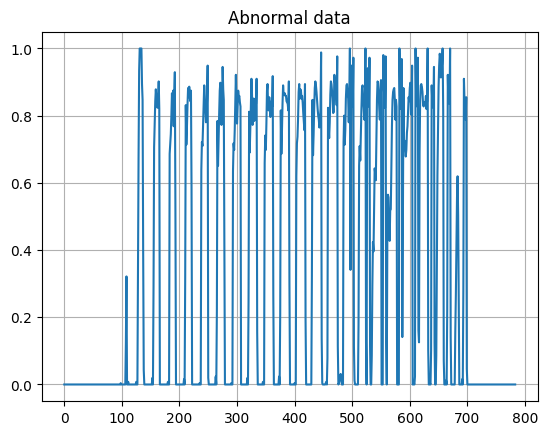

In [284]:
plt.grid()
plt.plot(np.arange(784), anom_train_data[0])
plt.title("Abnormal data")
plt.show()

In [285]:
# Input image
input_img = Input(shape=(784,))

# encoder
encoded = Dense(256, activation='relu')(input_img)
encoded = BatchNormalization()(encoded)
encoded = Dense(128, activation='relu', kernel_regularizer=L1L2(l1=1e-5, l2=1e-5))(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

# decoder
decoded = Dense(32, activation='relu', kernel_regularizer=L1L2(l1=1e-5, l2=1e-5))(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

In [286]:
autoencoder = Model(input_img, decoded)

In [287]:
autoencoder.compile(optimizer='adam', loss='mse')

In [288]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=100, batch_size=512, shuffle=True,
                          validation_data=(test_data, test_data), callbacks=[early_stopping])

Epoch 1/100


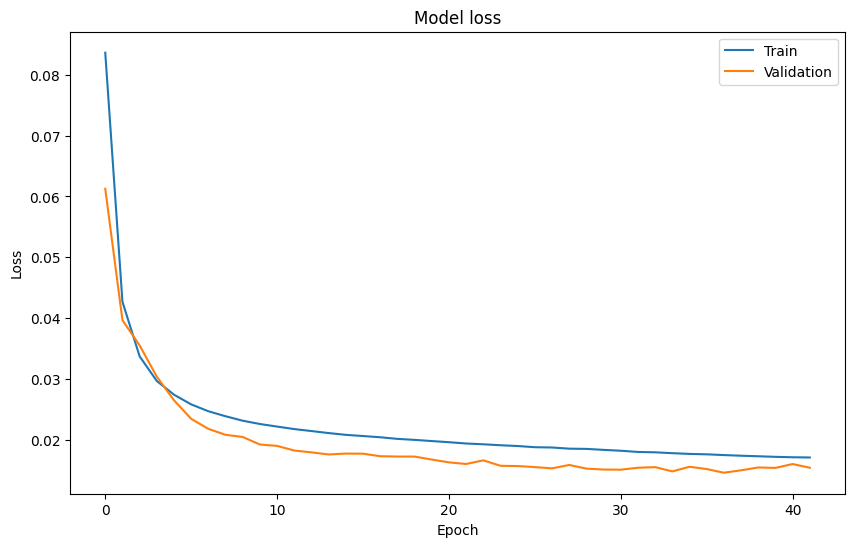

In [ ]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

1750/1750 [==============================] - 3s 2ms/step


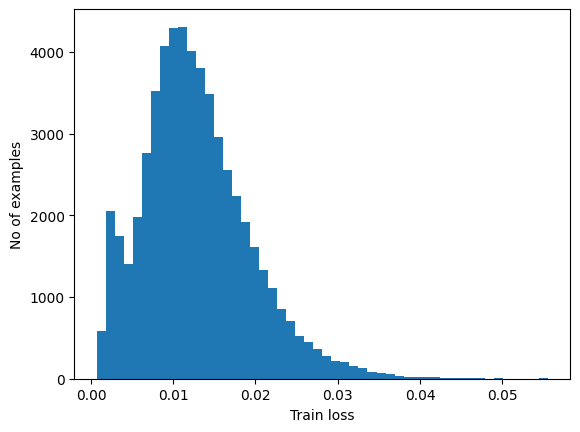

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mse(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold)

Threshold  0.019335568


18/18 [==============================] - 0s 2ms/step


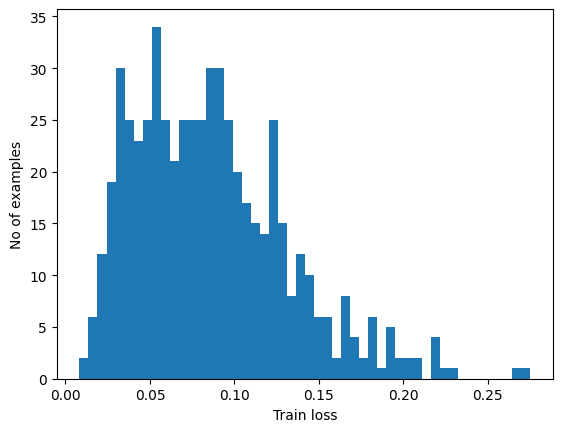

In [ ]:
reconstructions = autoencoder.predict(anom_train_data)
train_loss = tf.keras.losses.mse(reconstructions, anom_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [ ]:
threshold_anom = np.mean(train_loss) + np.std(train_loss)
print("Threshold ", threshold_anom)

Threshold  0.13142824


In [ ]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mse(reconstructions, data)
    return tf.math.less(loss, threshold)

def get_metrics(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    report = classification_report(labels, predictions, target_names=['anomaly', 'normal'])
    cm = confusion_matrix(labels, predictions)
    return accuracy, precision, recall, report, cm


def print_stats(accuracy, precision, recall, report, cm):
    print("Accuracy = {}".format(accuracy))
    print("Precision = {}".format(precision))
    print("Recall = {}".format(recall))
    print("Report\n {}".format(report))
    print("Confusion Matrix")
    print(cm)

In [ ]:
preds = predict(autoencoder, test_data, threshold)
a, p, r, report, cm = get_metrics(preds, test_labels)
print_stats(a, p, r, report, cm)

Accuracy = 0.8356435643564356
Precision = 0.9995725765088049
Recall = 0.8344990008564088
Report
               precision    recall  f1-score   support

     anomaly       0.05      0.96      0.10       128
      normal       1.00      0.83      0.91     14012

    accuracy                           0.84     14140
   macro avg       0.52      0.90      0.50     14140
weighted avg       0.99      0.84      0.90     14140

Confusion Matrix
[[  123     5]
 [ 2319 11693]]


In [ ]:
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 123
False Positives: 5
False Negatives: 2319
True Positives: 11693


<Axes: >

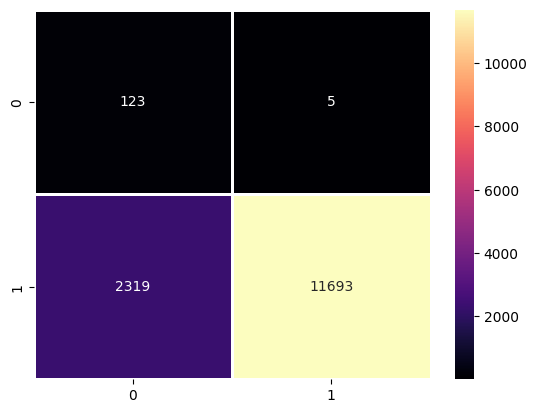

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', linewidths=1)

In [ ]:
def pr_auc_plot(predicitons, labels):
    precision_curve, recall_curve, _ = precision_recall_curve(labels, predicitons)
    print(threshold)
    pr_auc = auc(recall_curve, precision_curve)
    # Plot the precision-recall curve
    plt.figure()
    plt.plot(r, p, color='darkorange', lw=2, label='PR Curve (area = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()
    print()

In [ ]:
def roc_plot(predicitons, labels):
    fpr, tpr, thresholds = roc_curve(labels, predicitons)
    roc_auc = roc_auc_score(labels, predicitons)
    # Plot ROC curve, FPR vs TPR, and True Positive Rate vs Threshold in a single plot
    plt.figure(figsize=(12, 8))

    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Plot False Positive Rate vs Threshold
    plt.plot(thresholds, fpr, color='blue', lw=2, label='False Positive Rate (FPR)')

    # Plot True Positive Rate vs Threshold
    plt.plot(thresholds, tpr, color='green', lw=2, label='True Positive Rate (TPR)')

    # Set labels and title
    plt.xlabel('Threshold')
    plt.ylabel('Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve and Rates vs Threshold')
    plt.legend(loc='lower right')

    # Show the combined plot
    plt.show()

0.019335568


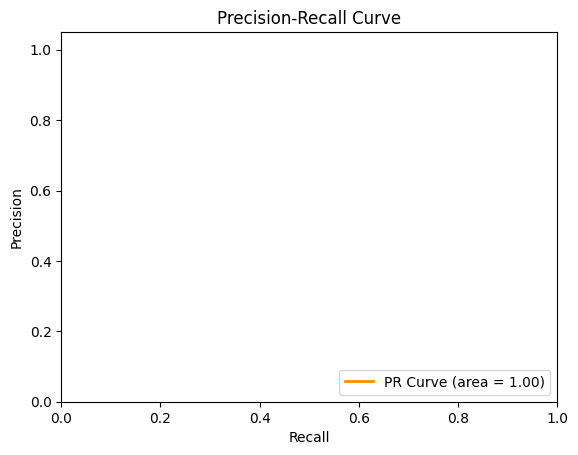

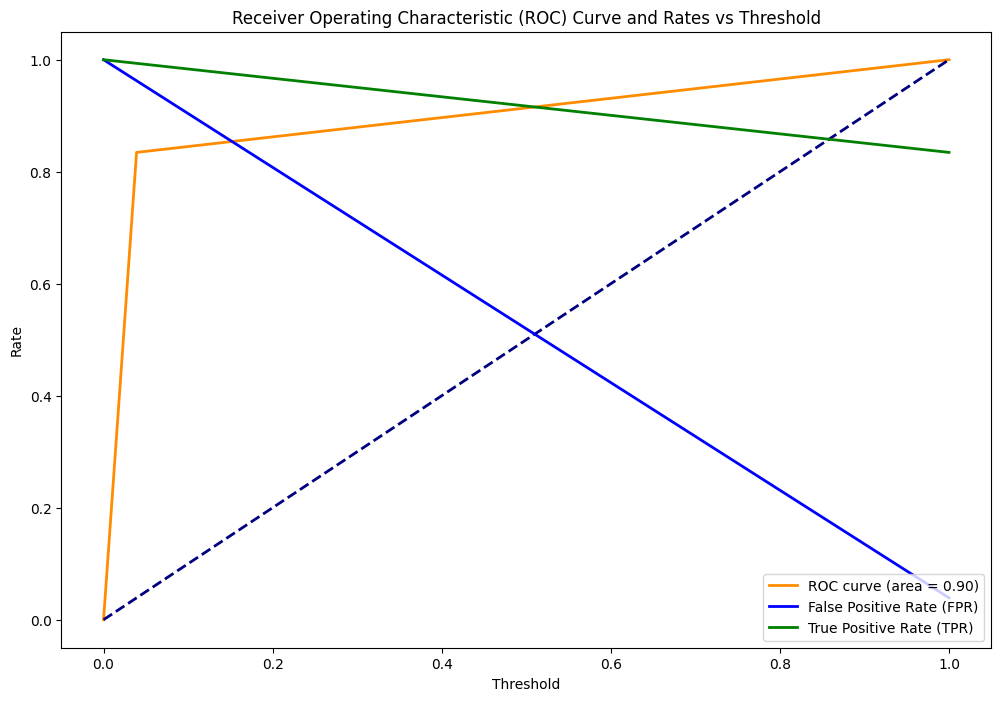

In [ ]:
pr_auc_plot(preds, test_labels)
roc_plot(preds, test_labels)